In [303]:
import jax
jax.config.update("jax_enable_x64", True)
# jax.config.update("jax_debug_nans", True)
import jax.numpy as jnp
from jax.example_libraries.stax import Tanh, Softplus, LeakyRelu
import pandas as pd
import optax

In [304]:
from model.nn import RealNVP, make_transform
from model.loss import make_error_loss

In [305]:
dim = 3
nlayers = 12
hidden = 6
activation = Tanh

transform = make_transform(hidden, activation)
flow_init = RealNVP(transform, nlayers)

rng = jax.random.PRNGKey(42)
init_rng, rng = jax.random.split(rng)
params, flow_forward, flow_inverse = flow_init(init_rng, dim)

# basis = lambda tau: jnp.array([1.0, (tau[0]**2 - tau[1]**2)**2, tau[2]**2])
order = [6, 6, 5]
# indepent poly
def basis(tau):
    b = [1.0]
    for idx in range(dim):
        for power in range(1, order[idx]+1):
            b.append(tau[idx]**power)
    return jnp.array(b)
# # mixed poly
# def basis(tau):
#     b = []
#     for n0 in range(order+1):
#         for n1 in range(0, order - n0 + 1):
#             for n2 in range(0, order - n0 - n1 + 1):
#                 b.append(tau[0]**n0 * tau[1]**n1 * tau[2]**n2)
#     return jnp.array(b)

_, train_loss, coefficients = make_error_loss(flow_forward, basis, "./h3/pes_morse_train.txt")
valid_loss, _, _ = make_error_loss(flow_forward, basis, "./h3/pes_morse_valid.txt")
test_loss, _, _ = make_error_loss(flow_forward, basis, "./h3/pes_morse_test.txt")
value_and_grad = jax.value_and_grad(train_loss, argnums=0, has_aux=False)

step_size = 5e-4

params_optimizer = optax.adam(step_size)
params_opt_state = params_optimizer.init(params)

In [306]:
@jax.jit
def step(params, params_opt_state):
    value, grad = value_and_grad(params)
    params_updates, params_opt_state = params_optimizer.update(grad, params_opt_state)
    params = optax.apply_updates(params, params_updates)
    return value, params, params_opt_state

In [307]:
train_loss_history = []
valid_loss_history = []
# test_loss_history = []
nsteps = 3000
for i in range(nsteps):
    value, params, params_opt_state = step(params, params_opt_state)
    u = coefficients(params)
    train_loss_history.append(value)
    valid_loss_history.append(valid_loss(params, u))
    # test_loss_history.append(test_loss(params, u0))
    print(i, value)
# print(u0)
print(test_loss(params, u))
output = flow_inverse(params, jnp.array([[0, 0, 0]]))

0 0.0011547049185077068
1 0.0008080769602435284
2 0.0005471562811911468
3 0.00035567374719622236
4 0.00021956912540538331
5 0.00013182741983903956
6 0.00010010133465970794
7 0.0001326445215599631
8 0.00018674910163661573
9 0.0002209995747224497
10 0.0002266119925913579
11 0.00020980588236364783
12 0.00018052038307454776
13 0.00014812488193528817
14 0.00012072622771042152
15 0.00010370937904506661
16 9.730289888951194e-05
17 9.788651498249257e-05
18 0.00010153820357634846
19 0.00010562387986297328
20 0.00010870912927643528
21 0.00011013884308766486
22 0.00010972633371808538
23 0.00010756651705044751
24 0.00010392545444648515
25 9.917257122724066e-05
26 9.373670689113989e-05
27 8.80747781418223e-05
28 8.26447195351604e-05
29 7.787483188870237e-05
30 7.412222662947499e-05
31 7.161792392516853e-05
32 7.0408766954827e-05
33 7.03231370558638e-05
34 7.09927752703815e-05
35 7.194119992488812e-05
36 7.271040999533296e-05
37 7.297473893567996e-05
38 7.260201646408504e-05
39 7.165157201580175e-05

/var/folders/hf/60jhbx_s40b92cvfxl5gbbb80000gn/T/ipykernel_5995/2068783962.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


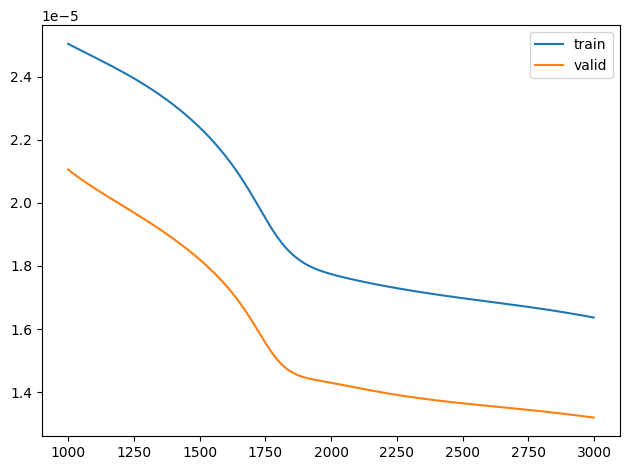

In [308]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
start_step = 1000
ax.plot(range(start_step, nsteps), train_loss_history[start_step:nsteps], label = "train")
ax.plot(range(start_step, nsteps), valid_loss_history[start_step:nsteps], label = "valid")
# ax.plot(range(start_step, nsteps), test_loss_history[start_step:nsteps], label = "test")
ax.legend(loc="upper right")
fig.tight_layout()
fig.show()

In [309]:
print(output[0])

[-0.19895382 -0.06807625  0.08256551]


In [310]:
# print(jnp.acos(output[0][0]) * 180 / jnp.pi)
# print(-jnp.log(output[0][1]))
# print(-jnp.log(output[0][2]))

In [311]:
print(u)

[ 1.11390275e+01 -2.58453979e+00  6.98247153e+00 -1.00563444e+01
  8.21244702e+00 -3.35983659e+00  5.42864560e-01  4.25248215e+00
 -1.35988149e+01  1.92924736e+01 -1.28181201e+01  3.06627530e+00
  2.41639196e-01  2.86462584e+02  2.92912232e+03  1.49296984e+04
  3.77601470e+04  3.78861784e+04]


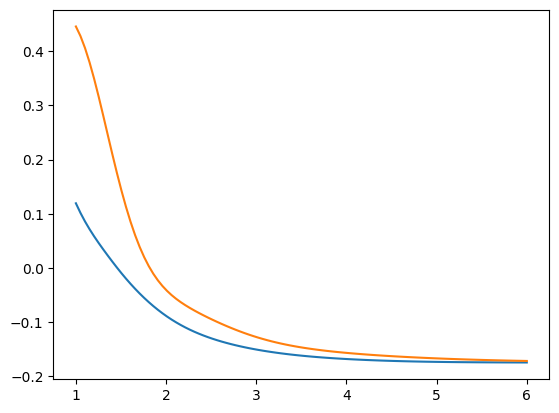

In [312]:
theta = jnp.pi / 4
r_h2 = 0.7414 / 0.53
r = jnp.linspace(1, 6, 100)
inputs = jnp.array([jnp.exp(-jnp.array([r_h2, rr, jnp.sqrt(r_h2**2 + rr**2 - 2*rr*r_h2*jnp.cos(theta))])) for rr in r])
outputs = flow_forward(params, inputs)
transformed_pes = lambda tau: jnp.dot(u, basis(tau))
energy = jax.vmap(transformed_pes)(outputs)

from h3.bkmp2 import bkmp2
bkmp2_inputs = jnp.array([[r_h2, rr, jnp.sqrt(r_h2**2 + rr**2 - 2*r_h2*rr*jnp.cos(theta))] for rr in r])
bkmp2_energy = [bkmp2(i, 0)[0] for i in bkmp2_inputs]

plt.plot(r, bkmp2_energy)
plt.plot(r, energy)
plt.show()

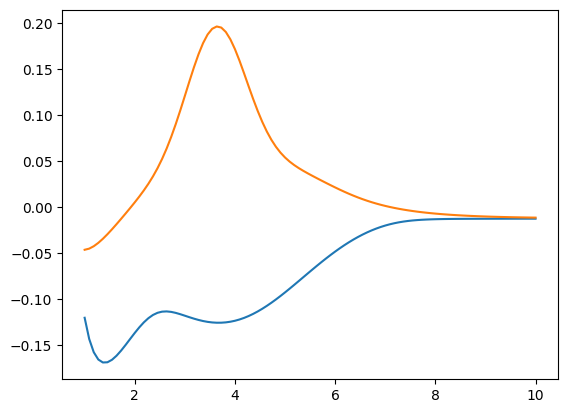

In [313]:
theta = jnp.pi / 6
r_h2 = 0.7414 / 0.53 * 3
r = jnp.linspace(1, 10, 100)
inputs = jnp.array([jnp.exp(-jnp.array([r_h2, rr, jnp.sqrt(r_h2**2 + rr**2 - 2*rr*r_h2*jnp.cos(theta))])) for rr in r])
outputs = flow_forward(params, inputs)
transformed_pes = lambda tau: jnp.dot(u, basis(tau))
energy = jax.vmap(transformed_pes)(outputs)

from h3.bkmp2 import bkmp2
bkmp2_inputs = jnp.array([[r_h2, rr, jnp.sqrt(r_h2**2 + rr**2 - 2*r_h2*rr*jnp.cos(theta))] for rr in r])
bkmp2_energy = [bkmp2(i, 0)[0] for i in bkmp2_inputs]

plt.plot(r, bkmp2_energy)
plt.plot(r, energy)
plt.show()